<a href="https://colab.research.google.com/github/maryamajarmeh/Computer-Vision-Intern/blob/main/Water_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install rasterio

In [23]:
import zipfile
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
import numpy as np
import rasterio
from sklearn.model_selection import train_test_split


In [2]:
# Unzip DataSet
local_zip = '/content/water_dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/water DataSet')


zip_ref.close()
print("Dataset extracted successfully!")

Dataset extracted successfully!


In [3]:
base_dir = '/content/water DataSet/water_dataset'

images_dir = os.path.join(base_dir, 'images')
labels_dir   = os.path.join(base_dir, 'labels')

In [4]:
image_files = sorted(os.listdir(images_dir))
label_files = sorted(os.listdir(labels_dir))

print("Number of images:", len(image_files))
print("Number of labels:", len(label_files))

Number of images: 306
Number of labels: 456


In [5]:
print("First 10 image files:")
print(image_files[:10])

print("\nFirst 10 label files:")
print(label_files[:10])


First 10 image files:
['0.tif', '1.tif', '10.tif', '100.tif', '101.tif', '102.tif', '103.tif', '104.tif', '105.tif', '106.tif']

First 10 label files:
['0.png', '1.png', '10.png', '100.png', '100_184.png', '101.png', '101_89.png', '102.png', '102_179.png', '103.png']


In [6]:
clean_label_files = [f for f in label_files if "_" not in f]

print("Clean labels count:", len(clean_label_files))


Clean labels count: 306


In [7]:
image_files = sorted(image_files)
label_files = sorted(clean_label_files)

print("Images:", len(image_files))
print("Labels:", len(label_files))


Images: 306
Labels: 306


**Using rasterio library**

In [10]:
sample_image_path = os.path.join(images_dir, image_files[0])

with rasterio.open(sample_image_path) as src:
    image = src.read()

print("Raw shape (bands, H, W):", image.shape)


Raw shape (bands, H, W): (12, 128, 128)


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


In [11]:
image = np.transpose(image, (1, 2, 0))

print("Transposed shape (H, W, bands):", image.shape)
print("Data type:", image.dtype)
print("Min value:", image.min())
print("Max value:", image.max())


Transposed shape (H, W, bands): (128, 128, 12)
Data type: int16
Min value: -28
Max value: 4975


In [14]:
sample_label_path = os.path.join(labels_dir, label_files[0])

mask = plt.imread(sample_label_path)
mask = (mask > 0).astype(np.float32)

print("Mask shape:", mask.shape)
print("Unique mask values:", np.unique(mask))


Mask shape: (128, 128)
Unique mask values: [0. 1.]


**Visualization**

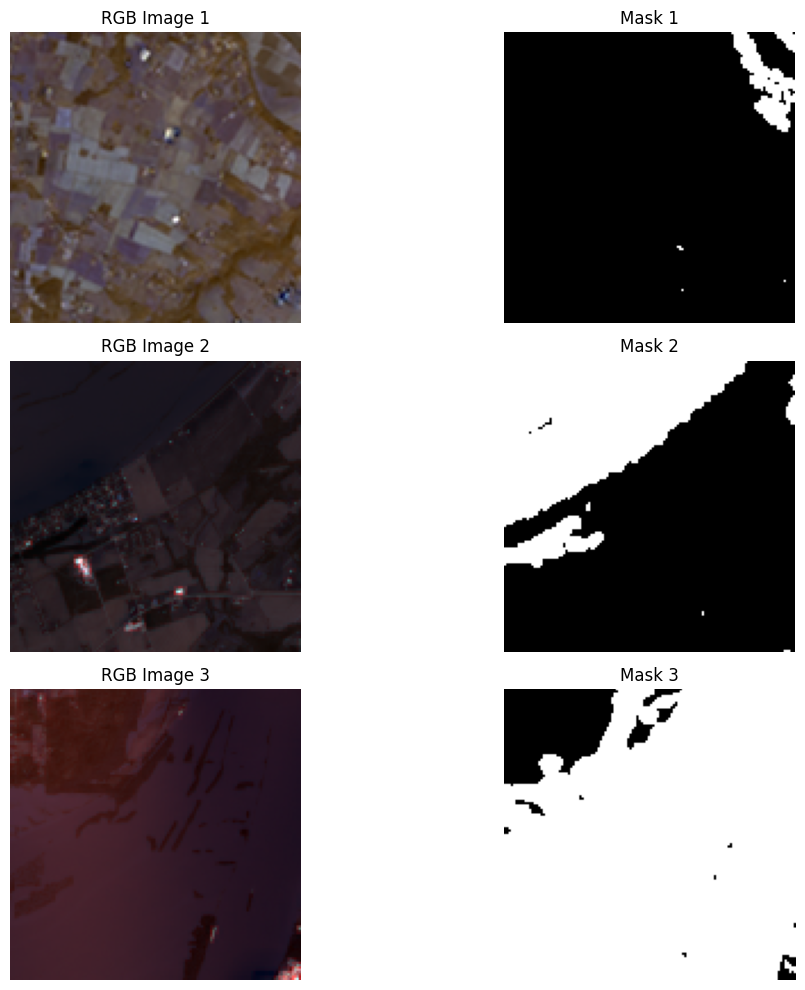

In [21]:
def load_image(path):
    with rasterio.open(path) as src:
        img = src.read()  # (bands, H, W)
        img = np.transpose(img, (1, 2, 0))  # (H, W, bands)
    return img

def load_mask(path):
    mask = plt.imread(path)
    mask = (mask > 0).astype(np.float32)
    return mask

def normalize_rgb(image):
    rgb = image[:, :, :3].astype(np.float32)

    for i in range(3):
        band = rgb[:, :, i]
        rgb[:, :, i] = (band - band.min()) / (band.max() - band.min() + 1e-8)

    return rgb

indices = random.sample(range(len(image_files)), 3)

plt.figure(figsize=(12, 10))

for i, idx in enumerate(indices):
    img_path = os.path.join(images_dir, image_files[idx])
    mask_path = os.path.join(labels_dir, label_files[idx])

    image = load_image(img_path)
    mask = load_mask(mask_path)
    rgb_display = normalize_rgb(image)

    plt.subplot(3, 2, 2*i + 1)
    plt.imshow(rgb_display)
    plt.title(f"RGB Image {i+1}")
    plt.axis("off")


    plt.subplot(3, 2, 2*i + 2)
    plt.imshow(mask, cmap="gray")
    plt.title(f"Mask {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


**Normalization**

In [25]:
# Normalize all bands (per image)
def normalize_all_bands(image):
    image = image.astype(np.float32)
    for i in range(image.shape[-1]):
        band = image[:, :, i]
        image[:, :, i] = (band - band.min()) / (band.max() - band.min() + 1e-8)
    return image

X = np.array([normalize_all_bands(img) for img in X])

**Split Train / Validation**

In [26]:
images = []
masks = []

for img_file, mask_file in zip(image_files, label_files):
    img_path = os.path.join(images_dir, img_file)
    mask_path = os.path.join(labels_dir, mask_file)

    images.append(load_image(img_path))
    masks.append(load_mask(mask_path))

X = np.array(images)
y = np.array(masks)
y = np.expand_dims(y, axis=-1)
print("X shape:", X.shape)   # (N, 128,128,12)
print("y shape:", y.shape)   # (N,128,128,1)


X shape: (306, 128, 128, 12)
y shape: (306, 128, 128, 1)


In [27]:

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)


Train: (244, 128, 128, 12)
Validation: (62, 128, 128, 12)


**Model** **Building**

In [28]:
def unet_model(input_shape=(128,128,12)):
    inputs = keras.layers.Input(input_shape)

    # Encoder
    c1 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = keras.layers.MaxPooling2D()(c1)

    c2 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = keras.layers.MaxPooling2D()(c2)

    c3 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(c3)

    # Decoder
    u4 = keras.layers.UpSampling2D()(c3)
    u4 = keras.layers.Concatenate()([u4, c2])
    c4 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(u4)
    c4 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(c4)

    u5 = keras.layers.UpSampling2D()(c4)
    u5 = keras.layers.Concatenate()([u5, c1])
    c5 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(u5)
    c5 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c5)

    outputs = keras.layers.Conv2D(1, 1, activation='sigmoid')(c5)

    model = keras.Model(inputs, outputs)
    return model

model = unet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      6,976 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 192)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │    110,656 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_8[0][0]  

 Total params: 1,888,321 (7.20 MB)

 Trainable params: 1,888,321 (7.20 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryIoU(threshold=0.5),
        tf.keras.metrics.Precision(thresholds=0.5),
        tf.keras.metrics.Recall(thresholds=0.5),
    ]
)

In [30]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [31]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=8,
    callbacks=[early_stop]
)

Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 793ms/step - binary_io_u: 0.5304 - loss: 64.8022 - precision: 0.5188 - recall: 0.6175 - val_binary_io_u: 0.7141 - val_loss: 1.9865 - val_precision: 0.9548 - val_recall: 0.5620
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - binary_io_u: 0.6797 - loss: 1.6649 - precision: 0.7864 - recall: 0.6272 - val_binary_io_u: 0.6978 - val_loss: 0.3709 - val_precision: 0.8517 - val_recall: 0.5832
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - binary_io_u: 0.7170 - loss: 0.3570 - precision: 0.8549 - recall: 0.6545 - val_binary_io_u: 0.7351 - val_loss: 0.2999 - val_precision: 0.8182 - val_recall: 0.6844
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - binary_io_u: 0.7460 - loss: 0.3347 - precision: 0.8484 - recall: 0.7194 - val_binary_io_u: 0.7138 - val_loss: 0.2922 - val_precision: 0.8825 - val_recall: 0.5965
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - binary_io_u: 0.7391 - loss: 0.3043 - precision: 0.8820 - recall: 0.6856 - val_binary

In [32]:
model.evaluate(X_val, y_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step - binary_io_u: 0.7565 - loss: 0.2134 - precision: 0.8923 - recall: 0.6603


[0.21263353526592255,
 0.7737969160079956,
 0.9075183868408203,
 0.693581759929657]